In [20]:
############# NOTEBOOK PARAMETERS ##############

parameters = dict()
parameters['file'] = None # set to None for file prompt
parameters['dynamic_range'] = 40
parameters['interpolation'] = 'bilinear'
parameters['cmap'] = 'viridis'

################################################

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))

from notebook_functions import *
from mpl_toolkits import mplot3d as mp3d
from matplotlib import patches
from interaction3 import abstract


## FUNCTIONS ##

## SCRIPT ##

if parameters['file'] is None:
    parameters['file'] = open_file_dialog()

file = parameters['file']
arrays = abstract.load(file)
if not isinstance(arrays, (list, tuple)):
    arrays = list(arrays)

### <center>Notebook parameters</center>

In [2]:
display(HTML('<center>' + tabulate.tabulate(parameters.items(), tablefmt='html') + '</center>'))

file,C:/Bernie/Projects/interaction3/foldable_vernier.json
dynamic_range,40
interpolation,bilinear
cmap,viridis


### <center>Drawing</center>

Button(description='Export figures', style=ButtonStyle())

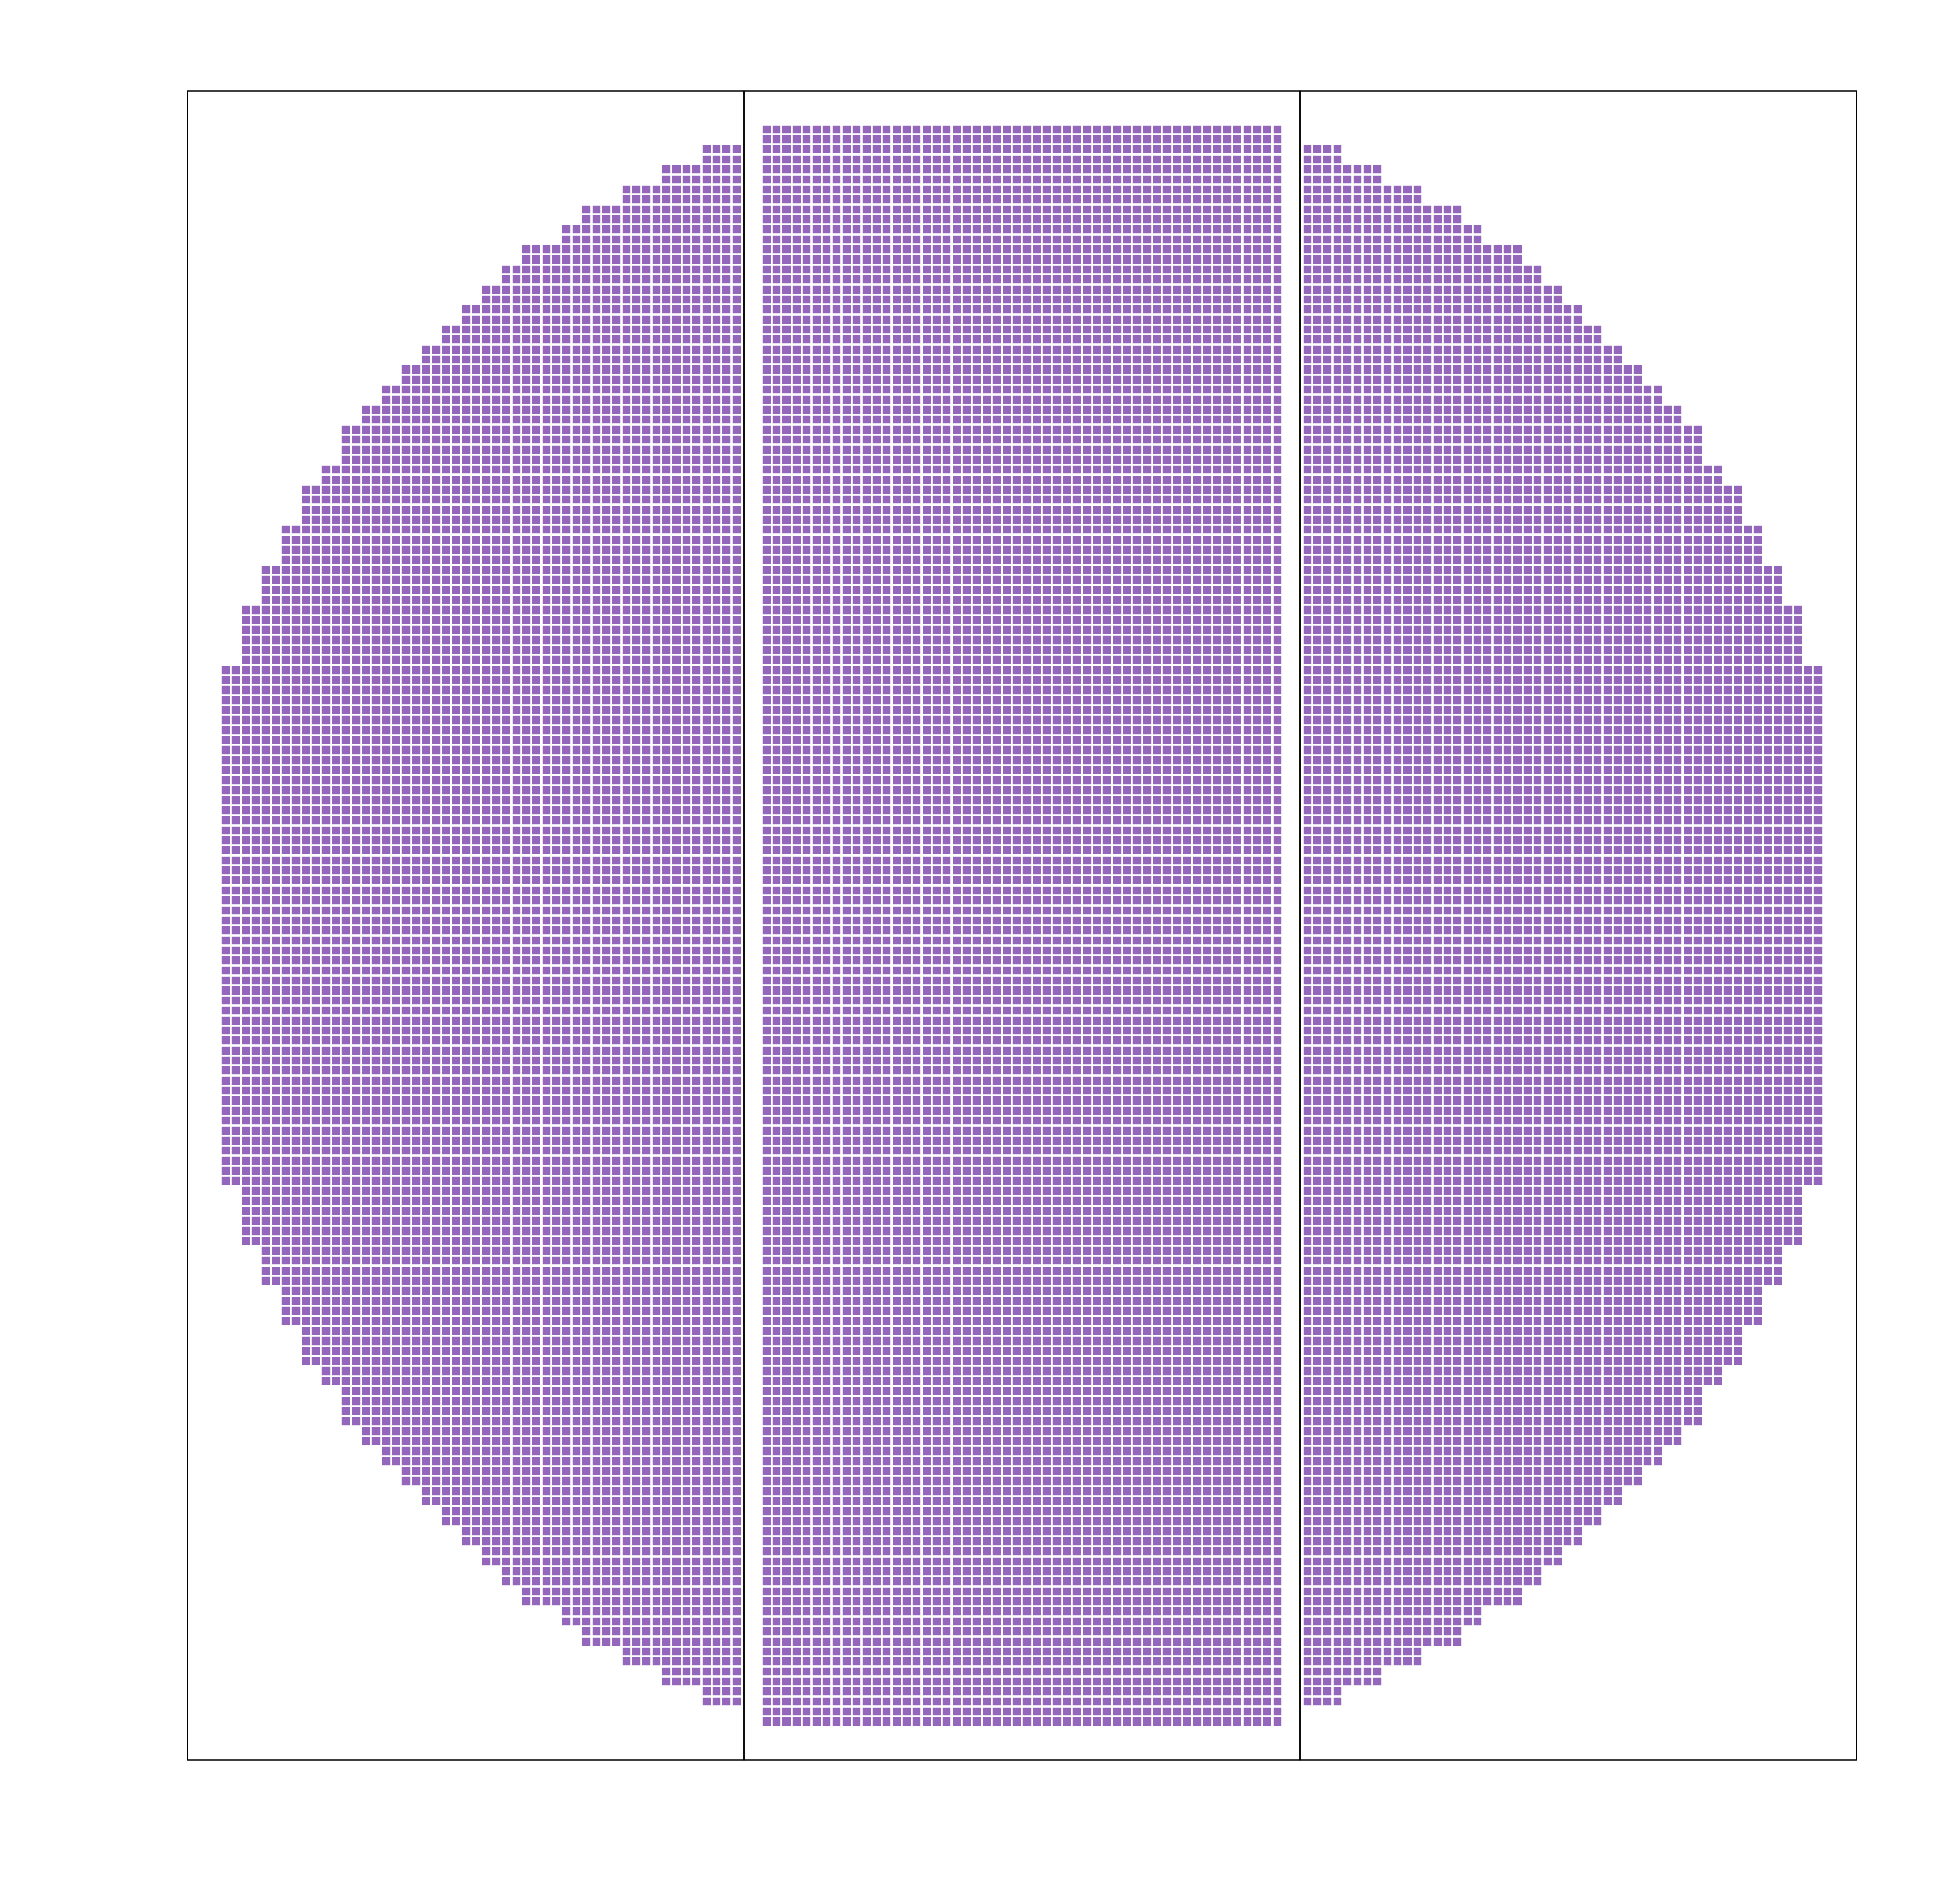

In [21]:
def plot(arrays):

    def rotate_nodes(nodes, vec, angle):
        rmatrix = rotation_matrix(vec, angle)
        return rmatrix.dot(nodes.T).T
    
    from matplotlib.collections import PatchCollection
    
    fig, ax = plt.subplots(figsize=(12, 12), dpi=300)
    
    collection = []
    
    for array in arrays:
        
        if 'vertices' in array:
            
            vertices = np.array(array['vertices'])
            poly = patches.Polygon(vertices[:, :2], lw=0.6)
            poly.set_edgecolor('black')
            poly.set_facecolor('none')
            collection.append(poly)
            
        for ch in array['channels']:

            kind = ch['kind'].lower()

            for elem in ch['elements']:
                for mem in elem['membranes']:

                    length_x = mem['length_x']
                    length_y = mem['length_y']
                    center = mem['position']
                    rotations = mem.get('rotations', None)

                    vertices = np.array([[-length_x / 2, -length_y / 2, 0],
                                         [-length_x / 2, length_y / 2, 0],
                                         [length_x / 2, length_y / 2, 0],
                                         [length_x / 2, -length_y / 2, 0]])

                    if rotations is not None:
                        for vec, angle in rotations:
                            vertices = rotate_nodes(vertices, vec, angle)

                    vertices = vertices + center

                    poly = patches.Polygon(vertices[:, :2], lw=0.1)
                    poly.set_edgecolor('black')
                    
                    if kind in ['transmit', 'tx']:
                        poly.set_color(red)
                    elif kind in ['receive', 'rx']:
                        poly.set_color(blue)
                    elif kind in ['both', 'txrx']:
                        poly.set_color(purple)
                    
                    collection.append(poly)
                    
    ax.add_collection(PatchCollection(collection, match_original=True))
    
    plt.tight_layout()
    
    # set limits
    centers = np.concatenate(abstract.get_membrane_positions_from_array(arrays), axis=0)
    xmax, ymax, _ = np.max(np.abs(centers), axis=0)
    xmax = xmax + 5e-4
    ymax = ymax + 5e-4
    maxdim = max(xmax, ymax)

    ax.set_xlim(-xmax, xmax)
    ax.set_ylim(-ymax, ymax)
    ax.set_axis_off()
    ax.set_aspect('equal')
    
#     proxy1 = patches.Rectangle((0,0), 1, 1, facecolor=red)
#     proxy2         = patches.Rectangle((0, 0), 1, 1, facecolor=blue)
#     leg = ax.legend([proxy1, proxy2], ['Transmit', 'Receive'], loc='best')
#     leg.get_frame().set_linewidth(0.7)
#     leg.draggable(state=True)

    return fig, collection


fig, coll = plot(arrays)
display(export_widget(fig));